In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model path
archive_path = '../../archive/model_spacy_processing_len2_ldalsionly'

In [79]:
# load dict and doc term matrixes
import pickle
obj_name_list = [
    'id2word', 
    'doc_term_matrix', 
    'doc_term_matrix_random_projections', 
    'doc_term_matrix_tfidf', 
    'doc_term_matrix_logentropy'
]
obj_list = []
for name in obj_name_list:
    with open(f'{archive_path}/model-server/dict_and_matrix/{name}.pkl', 'rb') as f:
        obj = pickle.load(f)
        obj_list.append(obj)
        print(obj)

Dictionary(34789 unique tokens: ['great', 'lunch', 'maui', 'ocean', 'overlook']...)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [80]:
filepath_hi = f'{archive_path}/data-server/processed/hi_rws_0001_0256_topics.csv'
df = pd.read_csv(filepath_hi)
models_list = [i.split('_topic_mode')[0] for i in df.columns if i.endswith('topic_mode')]
models_list

['lsi_5',
 'lsi_2',
 'lsi_8',
 'lsi_14',
 'lsi_logentropy',
 'lsi_11',
 'lda_2',
 'lda_5',
 'lda_8',
 'lda_11',
 'lda_14',
 'lsi_random_projections']

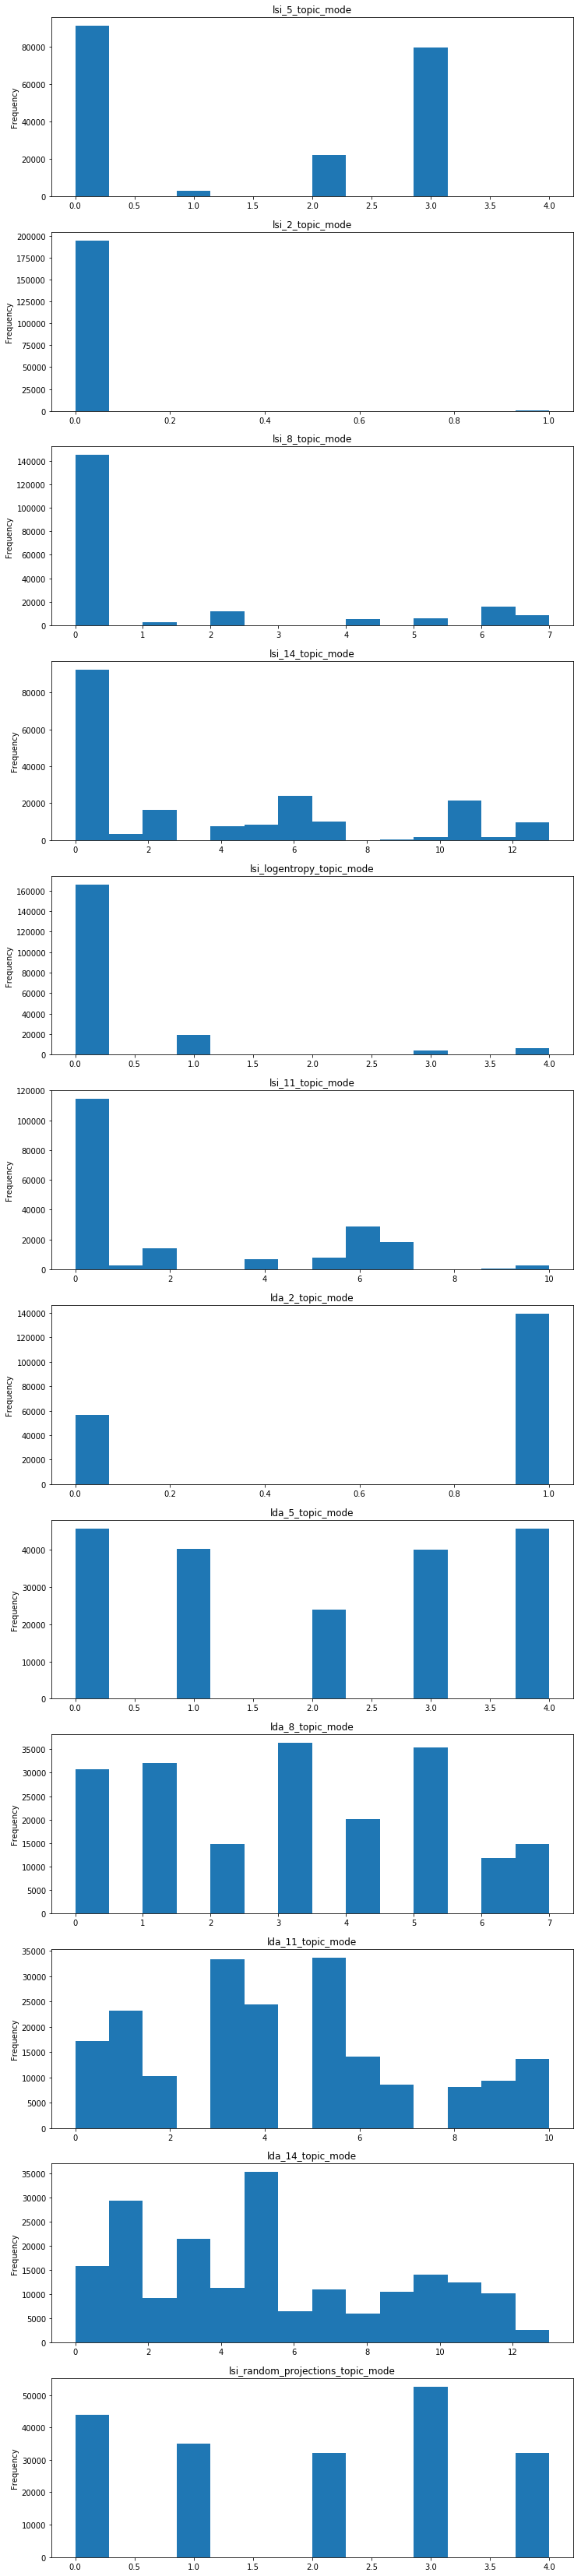

In [81]:
# topics value distribution
column_names = [i for i in df.columns if i.endswith('_mode')]
subplot_indexes = range(len(column_names))
fig, axes = plt.subplots(len(column_names), 1, figsize=(12,60))
for column_name, subplot_index in zip(column_names, subplot_indexes):
    index_row = 0 if subplot_index % 2 == 0 else 1
    df.loc[:,column_names[subplot_index]].plot(kind='hist', bins=14, ax=axes[subplot_index], title=column_name)

In [82]:
from gensim.models import LdaModel, LsiModel
from gensim.corpora import Dictionary
import itertools

loaded_models_list = []

for index, model in enumerate(models_list):
    model_path = f'{archive_path}/model-server/{model[:3]}_model/{model}.model'
    loaded_model = LdaModel.load(model_path) if model[:3] == 'lda' else LsiModel.load(model_path)
    print(f'{index}: <', loaded_model)
    loaded_models_list.append(loaded_model)

0: < LsiModel(num_terms=34789, num_topics=5, decay=1.0, chunksize=20000)
1: < LsiModel(num_terms=34789, num_topics=2, decay=1.0, chunksize=20000)
2: < LsiModel(num_terms=34789, num_topics=8, decay=1.0, chunksize=20000)
3: < LsiModel(num_terms=34789, num_topics=14, decay=1.0, chunksize=20000)
4: < LsiModel(num_terms=34789, num_topics=5, decay=1.0, chunksize=20000)
5: < LsiModel(num_terms=34789, num_topics=11, decay=1.0, chunksize=20000)
6: < LdaModel(num_terms=34789, num_topics=2, decay=0.5, chunksize=2000)
7: < LdaModel(num_terms=34789, num_topics=5, decay=0.5, chunksize=2000)
8: < LdaModel(num_terms=34789, num_topics=8, decay=0.5, chunksize=2000)
9: < LdaModel(num_terms=34789, num_topics=11, decay=0.5, chunksize=2000)
10: < LdaModel(num_terms=34789, num_topics=14, decay=0.5, chunksize=2000)
11: < LsiModel(num_terms=34789, num_topics=5, decay=1.0, chunksize=20000)


In [83]:
# rest of the code depends on here.
topic_model=loaded_models_list[7]
corpus=obj_list[1]
dictionary=obj_list[0]

In [84]:
# make a dataframe from words
topic_words = topic_model.show_topics(num_words=300, formatted=False)

topics_list = []
for (topic, word_list) in topic_words:
    temp = pd.DataFrame(word_list, columns=[f'{topic}_word', f'{topic}_prob'])
    topics_list.append(temp)
pd_topics = pd.concat(topics_list, axis=1)
pd_topics.to_csv(f'{archive_path}/data-server/processed/hi_rws_0001_0256_topics_words.csv', index=False)
pd_topics.head(10)

,0_word,0_prob,1_word,1_prob,2_word,2_prob,3_word,3_prob,4_word,4_prob
0,be,0.039594,place,0.056737,good,0.067672,food,0.086799,fish,0.022929
1,have,0.028705,maui,0.036683,lavender,0.024454,great,0.069644,order,0.022108
2,go,0.022055,restaurant,0.026579,be,0.021362,service,0.047935,be,0.021907
3,time,0.021692,will,0.018606,have,0.019442,good,0.035812,fresh,0.018390
4,take,0.020906,recommend,0.016562,enjoy,0.017131,amazing,0.027901,which,0.017120
5,love,0.020069,would,0.016462,lunch,0.017115,view,0.024903,burger,0.016389
6,come,0.016387,pizza,0.016167,drink,0.016161,friendly,0.021744,salad,0.014224
7,make,0.015728,visit,0.016009,menu,0.016161,price,0.021713,fry,0.011773
8,could,0.014310,beach,0.015713,coffee,0.013982,beautiful,0.019981,mahi,0.011418
9,table,0.013532,worth,0.015208,delicious,0.013206,nice,0.019959,dessert,0.010889


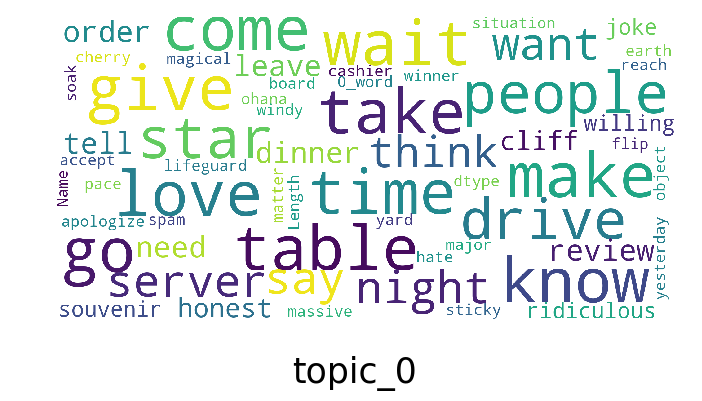

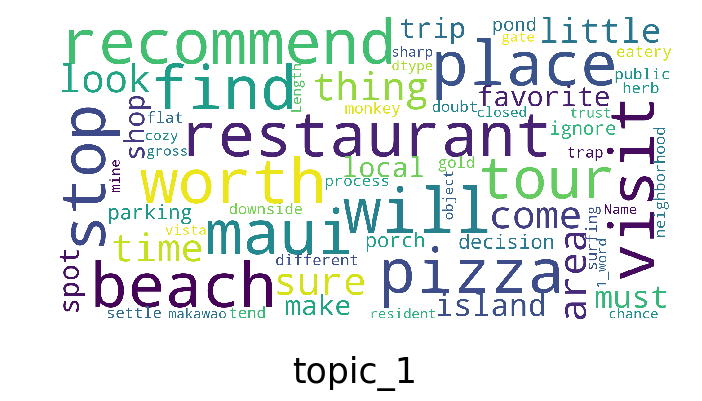

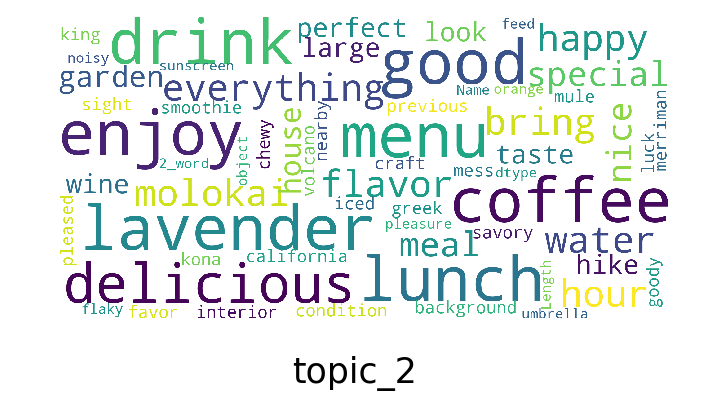

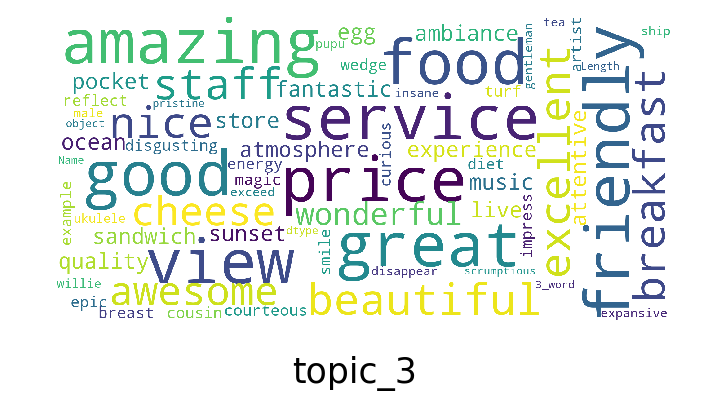

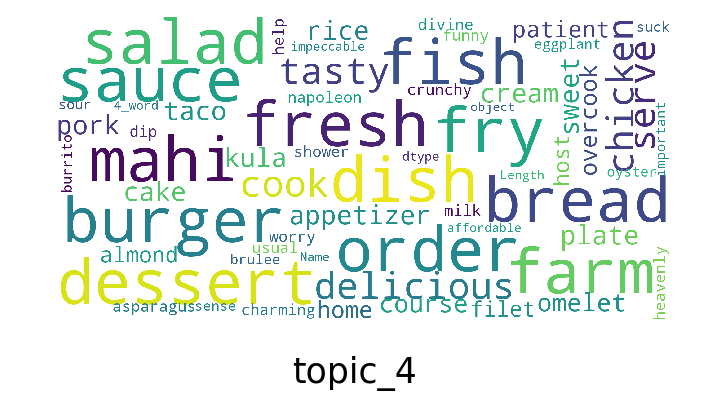

In [85]:
# words in the topics for selected model
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

for i in range(len(topics_list)):
    wordcloud = WordCloud(
            background_color='white',
            # stopwords=stopwords,
            max_words=400,
            max_font_size=40, 
            scale=5,
            random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(pd_topics[f'{i}_word']))
    wordcloud.to_file(f'{archive_path}/data-server/processed/hi_rws_0001_0256_topic_{i}.png')
    fig = plt.figure(1, figsize=(8, 8), dpi=100)    
    fig.suptitle(f'topic_{i}', fontsize=25)
    fig.subplots_adjust(top=2.3)
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [ ]:
# topic sent distribution per review
pd_topic_frequencies = df.lda_5_topic_mode_prob.apply(lambda x: pd.Series(x.split(',')).value_counts())
pd_topic_frequencies = pd_topic_frequencies.fillna(0).reindex(columns=sorted(pd_topic_frequencies))
pd_topic_frequencies.columns = [f'topic_{i}' for i in range(5)]
pd_topic_frequencies.head()

In [ ]:
# dump final data
data_path = f'{archive_path}/data-server/processed/hi_rws_0001_0256_descriptive.csv'
sentiments_path = f'{archive_path}/data-server/processed/hi_rws_0001_0256_sentiments.csv'
df1 = pd.read_csv(data_path)
df2 = pd.read_csv(sentiments_path)

# needed fixes
df1 = df1.drop([13914, 107036, 114094], axis=0)
df1.index = df1.reset_index(drop=True).index
df.lda_tfidf_topic_mode.name = 'topic_score'
df2['sgd.1'].name = 'sentiment_score'

df_final = pd.concat([df1, pd_topic_frequencies, df.lda_5_topic_mode, df2['sgd.1']], axis=1)
df_final.to_csv(f'{archive_path}/data-server/processed/hi_rws_0001_0256_final.csv', index=False)
df_final.info()

## Model Plots

In [81]:
# refactor 
hm = np.array([[y for (x,y) in topic_model[corpus[i]]] for i in range(len(corpus))])

In [88]:
hm[0]

[0.7042274755082566,
 -0.04130063391598843,
 -0.0024879705711419176,
 -1.2724995732831803,
 -1.697968364361942]

In [86]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0, perplexity=30)
tsne_embedding = tsne.fit_transform(hm)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding

ValueError: setting an array element with a sequence.

In [89]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(hm)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

ValueError: setting an array element with a sequence.

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=df.lsi_5_topic_mode, label=[0, 1, 2, 3, 4], title='test')) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [ ]:
from matplotlib import cm
plt.figure(figsize=(12,12))
plt.scatter(X_tsne[:,0], X_tsne[:,1], marker='.', cmap=cm.Paired, c=newsgroups_train.target[:n])
plt.axis('equal')
plt.show()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=topic_model, corpus=corpus, dictionary=id2word)